### BP for DNN

In [1]:
import numpy as np
from keras.utils import to_categorical
from sklearn import datasets
import matplotlib.pyplot as plt

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
D:\installation\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
class Layer(object):
    '''
    全连接层：中间层
    '''
    def __init__(self, input_dim, output_dim, activate='sigmoid'):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.normal(0,0.1,(input_dim, output_dim)) # W随机初始化: N(0,0.01)
        self.b = np.zeros((output_dim,)) # b初始化: 0
        self.act = activate

    def activate(self, a, grad=False):
        '''
        a: (batch_size, output_dim)
        return: (batch_size, output_dim)
        '''
        if self.act == 'sigmoid':
            h = 1/(1+np.exp(-a))
            if grad:
                return h*(1-h)
            return h
        elif self.act == 'tanh':
            h = np.tanh(a)
            if grad:
                return 1-h**2
            return h
        elif self.act == 'ReLU':
            h = np.piecewise(a, [a > 0, a <= 0], [lambda x: x, lambda x: 0]) + 0  # +0为了把array(x)转成x
            if grad:
                return np.piecewise(a, [a > 0, a <= 0], [lambda x: 1, lambda x: 0]) + 0 
            return h

    def forward(self, input_data):
        '''
        input_data: (batch_size, input_dim)
        return: (batch_size, output_dim)
        '''
        self.input_data = input_data
        self.a = self.input_data.dot(self.W) + self.b
        h = self.activate(self.a)
        return h

    def backward(self, input_grad, lr=0.01):
        '''
        BP in hidden layer
        input_grad: (batch_size, output_dim)  𝜕L/𝜕h for this layer
        return: (batch_size, input_dim)      𝜕L/𝜕h for previous layer
        '''
        batch_size = input_grad.shape[0]
        a_grad = self.activate(self.a, grad=True) * input_grad # 𝜕L/𝜕a (batch_size, output_dim)

        b_grad = a_grad.mean(axis=0) # 𝜕L/𝜕b (output_dim,)
        self.b -= lr * b_grad

        # 𝜕L/𝜕W (input_dim, output_dim)
        # (batch_size, 1, output_dim) * (batch_size, input_dim, 1) = (batch_size, input_dim, output_dim), then mean at axis=0
        W_grad = (a_grad.reshape(batch_size,1,self.output_dim)*self.input_data.reshape(batch_size,self.input_dim,1)).mean(axis=0)
        self.W -= lr * W_grad
    
        return a_grad.dot(self.W.T) 


        

In [6]:
class Output_layer(Layer):
    '''
    输出层：继承自中间层
    '''
    def __init__(self, input_dim, output_dim, activate='softmax'):
        super().__init__(input_dim, output_dim, activate='softmax')

    def activate(self, a):
        '''
        activate in output layer
        a: (batch_size, output_dim)
        return: (batch_size, output_dim)
            使用softmax默认使用cross entropy loss
            使用linear默认使用square loss
            这样使得输出层中：𝜕L/𝜕a = y_pred - y_train
        '''
        # softmax和linear对应分类/回归任务的输出层
        if self.act == 'softmax':
            h = np.exp(a)/(np.exp(a).sum(axis=1).reshape(a.shape[0],1)) 
            return h
        elif self.act == 'linear':
            return a
    
    def backward(self, input_grad, lr=0.01):
        '''
        BP in output layer
        input_grad: (batch_size, output_dim)  𝜕L/𝜕a for output layer, usually y_pred-y
        return: (batch_size, input_dim)       𝜕L/𝜕h for previous hidden layer
        '''
        batch_size = input_grad.shape[0]
        a_grad = input_grad          # 𝜕L/𝜕a (batch_size, output_dim)
        b_grad = a_grad.mean(axis=0) # 𝜕L/𝜕b (output_dim,)
        self.b -= lr * b_grad
        # 𝜕L/𝜕W (input_dim, output_dim)
        # (batch_size, 1, output_dim) * (batch_size, input_dim, 1) = (batch_size, input_dim, output_dim), then do average at axis=0
        W_grad = (a_grad.reshape(batch_size,1,self.output_dim)*self.input_data.reshape(batch_size,self.input_dim,1)).mean(axis=0)
        self.W -= lr * W_grad

        return input_grad.dot(self.W.T) 

In [4]:
# iris数据测试

iris = datasets.load_iris()
x = iris['data']
y = iris['target']
train_x = (x-x.mean(axis=0))/(x.std(axis=0))
train_y = to_categorical(y, num_classes=3)
print(x.shape, train_x.shape, y.shape, train_y.shape)

(150, 4) (150, 4) (150,) (150, 3)


In [7]:
# 单层softmax：逻辑回归多分类推广
ly = Output_layer(input_dim=4, output_dim=3, activate='softmax')

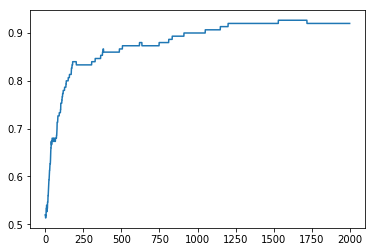

In [9]:
train_acc_set = []

for epoch in range(2000):
    y_pred = ly.forward(train_x)
    input_grad = y_pred - train_y # 𝜕L/𝜕a: softmax + cross_entropy
    g1 = ly.backward(input_grad)

    train_acc = (y_pred.argmax(axis=1)==y).sum()/y.size
    train_acc_set.append(train_acc)

plt.plot(train_acc_set)

In [20]:
# 3层神经网络：分类
ly1 = Layer(input_dim=4, output_dim=10, activate='tanh')
ly2 = Layer(input_dim=10, output_dim=5, activate='tanh')
ly3 = Output_layer(input_dim=5, output_dim=3, activate='softmax')

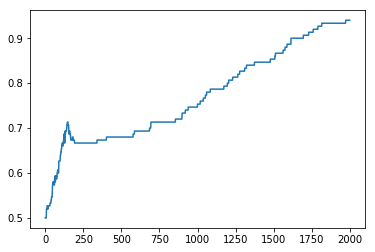

In [21]:
train_acc_set = []

for epoch in range(2000):
    # forward
    h1 = ly1.forward(train_x)
    h2 = ly2.forward(h1)
    y_pred = ly3.forward(h2)
    
    # 𝜕L/𝜕a: softmax + cross_entropy
    input_grad = y_pred - train_y 

    # backward
    g3 = ly3.backward(input_grad)
    g2 = ly2.backward(g3)
    g1 = ly1.backward(g2)

    train_acc = (y_pred.argmax(axis=1)==y).sum()/y.size
    train_acc_set.append(train_acc)

plt.plot(train_acc_set)